## Isolation Forest

Isolation Forest is a machine learning algorithm used mainly for anomaly detection (finding unusual or "outlier" data points that don't fit well with the rest of the data). It's especially helpful when you want to identify rare, unexpected events—like fraud detection or equipment failure prediction.

### How It Works:
1. **Random Splits**: The algorithm creates multiple decision trees by randomly splitting the data. Each split separates the data into smaller groups.
2. **Isolation of Anomalies**: Outliers (anomalies) are more isolated and separated from the majority of data points, so they need fewer splits to become "isolated" in a branch of a tree.
3. **Scoring**: The algorithm calculates a score based on how quickly a data point is isolated in a tree. Points that are isolated with fewer splits are considered more likely to be anomalies.

### What Is the Anomaly Score?
The anomaly score is a value between 0 and 1 that tells us how "isolated" a point is compared to the rest of the data. A higher anomaly score means the data point is more likely to be an anomaly (unusual or rare), while a lower score means it's similar to other points in the dataset.

### Score Calculation Formula:
![Anomaly Score Formula](Images\anomaly_score.png)

#### Where:
- `E(h(x))`: The average path length of x across the trees
- `c(n)`: It's a scaling factor to make scores easier to interpret, regardless of dataset size.It just adjusts the path length to account for the number of points in your dataset. This way, the anomaly score stays consistent even if you have a very large or small dataset.Without c(n), scores could vary too much with different dataset sizes, making it hard to interpret them reliably.

  <details>
  <summary>Examples of Anomaly Score Calculation</summary>

  Example 1: Small Dataset (10 Points)
  Suppose you have a small dataset of 10 points. You want to calculate the anomaly score for a specific point, Point A.

  Path Length: Let's say it takes 3 splits on average to isolate Point A in this small dataset.

  Calculate c(n):
  For a dataset of 10 points, c(10) will be a smaller number—around 4.5 (since there are fewer points to split).

  Anomaly Score:
  s(x,n) = 2^(-3/4.5) ≈ 2^(-0.67) ≈ 0.63

  Example 2: Large Dataset (1000 Points)
  Now, let's say you have a much larger dataset with 1000 points and you want to check the same point, Point A.

  Path Length: In this large dataset, Point A might take 8 splits on average to be isolated (since there are more points to go through).

  Calculate c(n):
  For a dataset of 1000 points, c(1000) will be around 14.5 (larger because there are more points).

  Anomaly Score:
  s(x,n) = 2^(-8/14.5) ≈ 2^(-0.55) ≈ 0.68

  Why c(n) Matters:
  Without c(n), scores would vary a lot based on the dataset size.
  Here, Point A gets similar scores (around 0.63 and 0.68) in both datasets, thanks to c(n).
  </details>

### Interpreting the Anomaly Score:
- Score close to 1: Likely an anomaly
- Score close to 0: Likely a normal point

--------------------------------------------------------------------------------

# Installing Libraries

In [22]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ML Model Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score,f1_score, roc_auc_score
from sklearn.ensemble import IsolationForest

# Warnings
import warnings
warnings.filterwarnings('ignore')

# For GAN Implementation 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Intro to Data

In [23]:
df = pd.read_csv('P:\Project\Machine Learning Projects\Anomaly_Detection_using_Isolation_Forest_with_AWS\Data_Set\Data_Set.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [24]:
print("Number of rows and columns:", df.shape)


Number of rows and columns: (6362620, 11)


In [25]:
#describing the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [26]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

# Handling the NULL Values

In [27]:
if df.isnull().values.any():
    print('There are some missing values in this dataset\n')
    df.dropna(inplace=True)
    print('Shape : ', df.shape) 
else:
    print('GREAT, There is no missing values in this dataset')

GREAT, There is no missing values in this dataset


# EDA of categories of the "type" feature


The feature 'type' contains the classes which is essential for the model to classify the data into the right class. So Label Encoding is applied on 'type' feature

In [28]:
print("Labels in feature type :- ",df['type'].unique())


Labels in feature type :-  ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


The counts of each category :-  type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


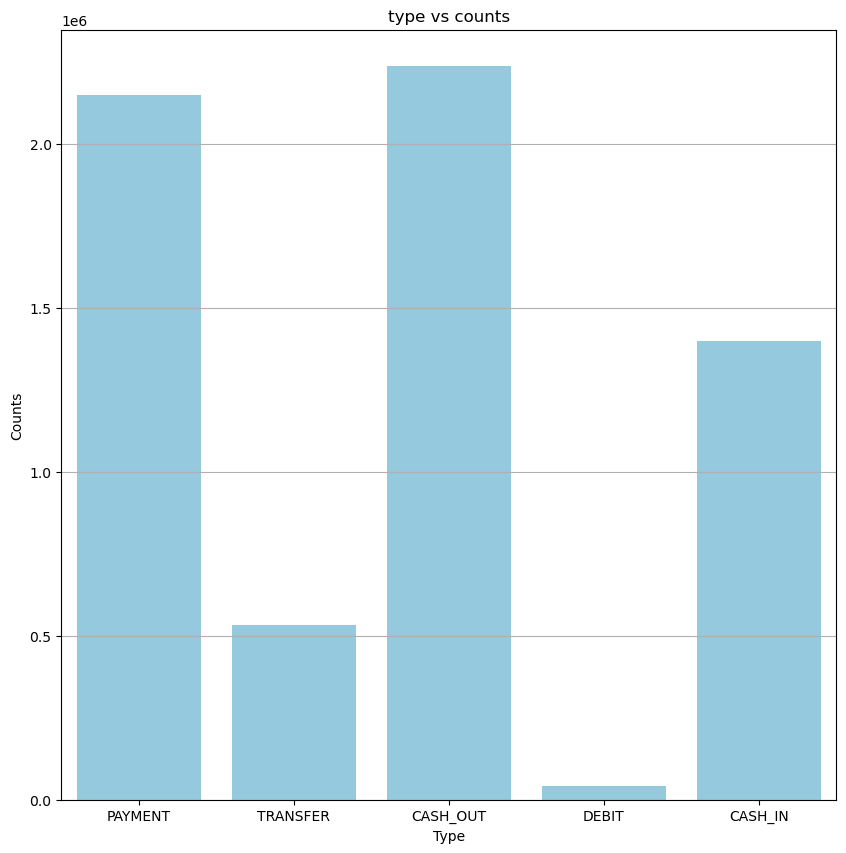

In [29]:
print("The counts of each category :- ",df['type'].value_counts())
plt.figure(figsize=(10,10))
plt.title('type vs counts')
sns.countplot(data=df, x='type', color='skyblue')
plt.xlabel('Type')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=1)
plt.show()

<h2>Label Encoding</h2>

In [30]:
df['type'].replace({'CASH_OUT':0, 'PAYMENT':1, 'CASH_IN':2, 'TRANSFER':3, 'DEBIT':4}, inplace=True)
df['type'].value_counts()

type
0    2237500
1    2151495
2    1399284
3     532909
4      41432
Name: count, dtype: int64

In [31]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,3,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,0,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Drop unnecessary columns

The column mentioned below were dropped as these features don't add any information during the training phase of the model 

In [32]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
df.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

# EDA of categories of the "isFraud" feature

In [33]:
print("The class in 'isFraud' feature :- ",df['isFraud'].unique())

The class in 'isFraud' feature :-  [0 1]


In [34]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

From the above summary we can see that the data is highly imbalanced. Where 0 repsresents a normal transaction and 1 represents an anomaly.

# Standardization

In [35]:
scaling_columns = ['amount', 'oldbalanceOrg', 'newbalanceDest']

# Standardizing the numerical columns for consistent scaling
scaler = StandardScaler()
df[scaling_columns] = scaler.fit_transform(df[scaling_columns])

# Check the transformed data
print(df.head())


   step  type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1     1 -0.281560      -0.229810       160296.36             0.0   
1     1     1 -0.294767      -0.281359        19384.72             0.0   
2     1     3 -0.297555      -0.288654            0.00             0.0   
3     1     0 -0.297555      -0.288654            0.00         21182.0   
4     1     1 -0.278532      -0.274329        29885.86             0.0   

   newbalanceDest  isFraud  isFlaggedFraud  
0       -0.333411        0               0  
1       -0.333411        0               0  
2       -0.333411        1               0  
3       -0.333411        1               0  
4       -0.333411        0               0  


# GAN implementation for Class Immbalance

What is a GAN?
A Generative Adversarial Network (GAN) consists of two neural networks:

    Generator: Creates fake (synthetic) data that resembles the real data.
    Discriminator: Tries to distinguish between real data (from the dataset) and fake data (from the generator).

They compete in a "game" where:

    The Generator improves at creating realistic data.
    The Discriminator gets better at identifying fake data.

Over time, the generator learns to produce data indistinguishable from the real dataset.

Leaky ReLU is a powerful activation function that improves upon the traditional ReLU by allowing small negative values to pass through. 

Optimizer is like a smart coach that helps neural networks learn better by adjusting their parameters (weights and biases) to minimize errors during training.

Adam optimizer is a popular and efficient type of optimizer that:

    Adapts the learning rate automatically for each parameter
    Combines the best aspects of two other optimization methods (RMSprop and Momentum)
    Works well for most deep learning tasks without requiring much tuning

In [36]:
# Define the Generator class
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  # First layer
            nn.LeakyReLU(0.2),  # Activation function
            nn.Linear(128, 256),  # Second layer
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),  # Output layer
            nn.Tanh()  # Ensures the generated output is in the range [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  # Input layer
            nn.LeakyReLU(0.2),  # Activation function
            nn.Dropout(0.3),  # Regularization to prevent overfitting
            nn.Linear(256, 128),  # Hidden layer
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),  # Output layer
            nn.Sigmoid()  # Ensures the output is between 0 and 1 for binary classification
        )

    def forward(self, x):
        return self.model(x)

In [37]:
# Hyperparameters
latent_dim = 100  # Size of the random noise input for the generator
input_dim = df.shape[1]  # The number of features in the data

# Initialize the generator and discriminator
generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

# Loss function and optimizers
adversarial_loss = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))  # Adam optimizer for generator
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))  # Adam optimizer for discriminator


<details>
<summary>GAN Training Process Overview</summary>


# GAN Training Process Overview





## Introduction
This code implements a Generative Adversarial Network (GAN) training process.






## Model Setup
- Uses Binary Cross-Entropy loss (BCELoss) for measuring how well the model is performing
- Creates two optimizers using Adam algorithm - one for the Generator and one for the Discriminator
- Learning rate is set to 0.0002 with specific beta parameters for stability





## Training Process
### The train_gan function:
- Takes number of epochs and batch size as inputs
- Runs in a loop for the specified number of epochs


### In each epoch:
#### Discriminator Training:
- Gets real data samples from dataset
- Creates fake data using the Generator
- Trains to correctly identify real data as 1 and fake data as 0
- Updates Discriminator weights based on its performance




#### Generator Training:
- Creates fake data
- Tries to fool the Discriminator by making fake data look real
- Updates Generator weights based on how well it fooled the Discriminator



## Monitoring
### Progress Tracking:
- Every 10 epochs, prints out the losses for both Generator and Discriminator

## Analogy
Think of it like a game where:
- Generator is an art forger trying to create fake paintings
- Discriminator is an art expert trying to spot the fakes
- They keep getting better at their jobs by competing with each other




## Outcome
This process helps create a model that can generate realistic-looking synthetic data similar to your original dataset.
</details>

In [38]:
# Function to train the GAN
def train_gan(epochs, batch_size):
    for epoch in range(epochs):
        # Train the Discriminator
        optimizer_D.zero_grad()

        # Real data
        real_data = torch.tensor(df.values[np.random.randint(0, df.shape[0], batch_size)], dtype=torch.float)
        real_labels = torch.ones(batch_size, 1)  # Labels for real data (1)

        # Fake data
        noise = torch.randn(batch_size, latent_dim)
        fake_data = generator(noise)  # Generate fake data using the generator
        fake_labels = torch.zeros(batch_size, 1)  # Labels for fake data (0)

        # Calculate discriminator loss on real and fake data
        real_loss = adversarial_loss(discriminator(real_data), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_data.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagation for discriminator
        d_loss.backward()
        optimizer_D.step()

        # Train the Generator
        optimizer_G.zero_grad()

        # Generate new fake data and try to fool the discriminator
        g_loss = adversarial_loss(discriminator(fake_data), real_labels)  # The generator tries to make fake data look real

        # Backpropagation for generator
        g_loss.backward()
        optimizer_G.step()

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Discriminator Loss: {d_loss.item()}, Generator Loss: {g_loss.item()}')


In [39]:
# Train the GAN for 1000 epochs (adjust the number of epochs based on your computational resources)
train_gan(epochs=1000, batch_size=64)

# Generate synthetic data without inverse scaling for now
def generate_synthetic_data(generator, num_samples):
    noise = torch.randn(num_samples, latent_dim)
    synthetic_data = generator(noise).detach().numpy()
    return synthetic_data  # Skipping inverse scaling for now

# Generate 1000 synthetic samples
synthetic_data = generate_synthetic_data(generator, num_samples=12000)
print(synthetic_data[:5])  # Display the first 5 synthetic samples

# Check the shape
print("Shape of synthetic data:", synthetic_data.shape)

Epoch 0, Discriminator Loss: 4.267470359802246, Generator Loss: 0.6759767532348633
Epoch 10, Discriminator Loss: 11.277383804321289, Generator Loss: 0.7342461347579956
Epoch 20, Discriminator Loss: 0.33068591356277466, Generator Loss: 0.7354987859725952
Epoch 30, Discriminator Loss: 1.1124582290649414, Generator Loss: 0.7308391332626343
Epoch 40, Discriminator Loss: 1.8910764455795288, Generator Loss: 0.7386904954910278
Epoch 50, Discriminator Loss: 0.32671216130256653, Generator Loss: 0.7360121607780457
Epoch 60, Discriminator Loss: 0.32628709077835083, Generator Loss: 0.7439643144607544
Epoch 70, Discriminator Loss: 0.3267744481563568, Generator Loss: 0.7508383989334106
Epoch 80, Discriminator Loss: 0.3442869484424591, Generator Loss: 0.6975757479667664
Epoch 90, Discriminator Loss: 0.38718676567077637, Generator Loss: 0.6828196048736572
Epoch 100, Discriminator Loss: 0.35975009202957153, Generator Loss: 0.6718767881393433
Epoch 110, Discriminator Loss: 0.354869544506073, Generator L

In [40]:
# Convert the synthetic data into a DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)

# Label the synthetic data as fraudulent
synthetic_df['isFraud'] = 1  # Assuming all synthetic data represents fraudulent transactions

# Now combine the real and synthetic datasets
combined_df = pd.concat([df, synthetic_df], ignore_index=True)

# Check the distribution of the target variable to see if the dataset is balanced
print(combined_df['isFraud'].value_counts())  # This will show the number of fraudulent and non-fraudulent samples

isFraud
0    6354407
1      20213
Name: count, dtype: int64


# Feature Extraction


Co-relation Matrix :- 


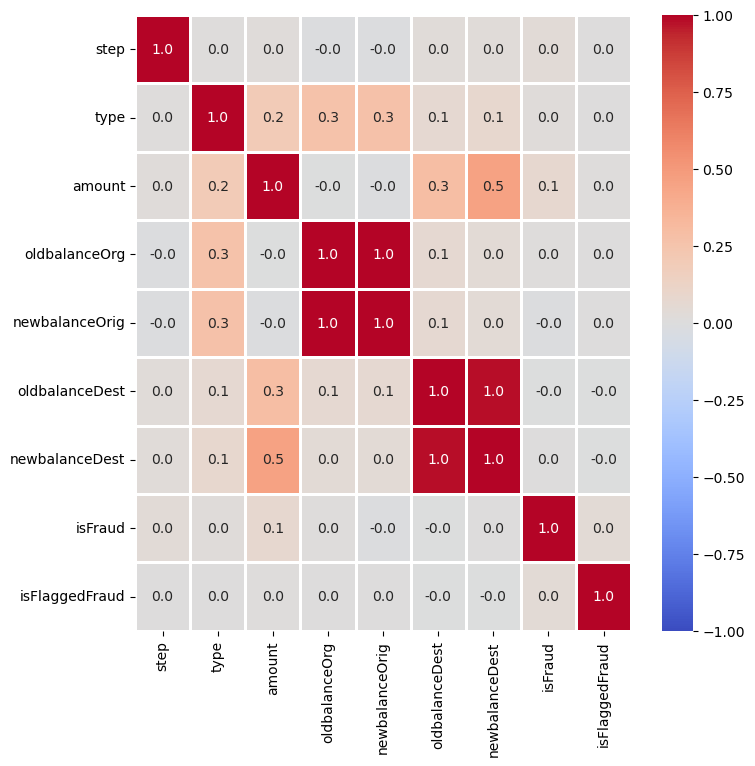

In [41]:
print("Co-relation Matrix :- ")
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), 
            annot=True, 
            linewidths=0.9, 
            fmt=".1f", vmin=-1, vmax=1,
            cmap='coolwarm')
plt.show()

# Dropping unnecessary columns based on correlation

In [42]:
df.drop(['newbalanceOrig', 'oldbalanceDest'], axis=1, inplace=True)
df.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceDest  float64
 5   isFraud         int64  
 6   isFlaggedFraud  int64  
dtypes: float64(3), int64(4)
memory usage: 339.8 MB


 # Splitting the data between train and target

In [44]:
# X Data
x = df.drop(['isFraud'], axis=1)
print('X shape is : ' , x.shape)
print()

# y Data
y = df['isFraud']
print('Y shape is : ' , y.shape)

X shape is :  (6362620, 6)

Y shape is :  (6362620,)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

# Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (4453834, 6)
X_test shape is  (1908786, 6)
y_train shape is  (4453834,)
y_test shape is  (1908786,)


# Training the ML Model 

In [46]:
def train_isolation_forest(df, contamination=0.01, random_state=42):
    # Scale the features

    features = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceDest']
    X = df[features]
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(df)
    
    # Create and train the Isolation Forest model
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=random_state,
        n_estimators=100,
        max_samples='auto'
    )
    
    # Fit the model and get predictions
    # Isolation Forest returns 1 for inliers and -1 for outliers
    predictions = iso_forest.fit_predict(X_scaled)
    
    # Convert predictions to binary (0 for normal, 1 for fraud)
    # Convert -1 to 1 (fraud) and 1 to 0 (normal)
    binary_predictions = np.where(predictions == -1, 1, 0)
    
    # Calculate evaluation metrics if true labels are available
    if 'isFraud' in df.columns:
        true_labels = df['isFraud']
        print("\nModel Performance:")
        print("\nClassification Report:")
        print(classification_report(true_labels, binary_predictions))
        
        # Create confusion matrix
        cm = confusion_matrix(true_labels, binary_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    # Add predictions to the original dataframe
    df['predicted_fraud'] = binary_predictions
    
    # Calculate anomaly scores
    anomaly_scores = iso_forest.score_samples(X_scaled)
    df['anomaly_score'] = anomaly_scores
    
    return {
        'model': iso_forest,
        'scaler': scaler,
        'predictions': binary_predictions,
        'anomaly_scores': anomaly_scores,
        'processed_data': df
    }


Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   6354407
           1       0.04      0.28      0.06      8213

    accuracy                           0.99   6362620
   macro avg       0.52      0.63      0.53   6362620
weighted avg       1.00      0.99      0.99   6362620



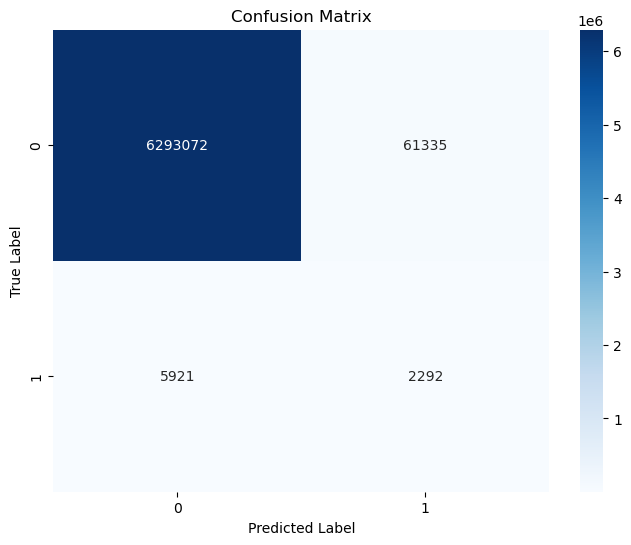

In [47]:
# Assuming your data is in a pandas DataFrame called 'df'

# Train the model
results = train_isolation_forest(df, contamination=0.01)

# Make predictions on new data
#new_predictions, new_scores = predict_new_transactions(results, new_data)

# Access the processed data with predictions and anomaly scores
processed_data = results['processed_data']

# Access the trained model and scaler for future use
trained_model = results['model']
trained_scaler = results['scaler']

# Predicting the New or Test data

In [48]:
def predict_new_transactions(model_dict, transaction_list):
    # Extract only the needed features (first 5 values)
    features = transaction_list[:5]
    
    # Reshape for single prediction
    X_new = np.array(features).reshape(1, -1)
    
    # Scale the features
    X_new_scaled = model_dict['scaler'].transform(X_new)
    
    # Get prediction
    prediction = model_dict['model'].predict(X_new_scaled)
    binary_prediction = 1 if prediction[0] == -1 else 0
    
    # Get anomaly score
    anomaly_score = model_dict['model'].score_samples(X_new_scaled)[0]
    
    return binary_prediction, anomaly_score

In [50]:
predict = [3009,0,98399999.64,17099999136.0,160299999996.36]
new_predictions, new_scores = predict_new_transactions(results, predict)
print(new_predictions , new_scores)

1 -0.8352936328758067
